# 📊 Comparativo de Modelos — Aprovação de Proposições

**Objetivo:** Comparar diversos algoritmos de classificação (Decision Tree, Random Forest, KNN, SVM e XGBoost) para prever se uma proposição legislativa será aprovada ou não.

Este notebook segue todos os passos de:
1. Carregamento e limpeza do dataset consolidado.
2. Pré-processamento (tratamento de colunas categóricas e numéricas).
3. Definição de pipelines para cada modelo.
4. Treino/Teste + avaliação de métricas (acurácia, precision, recall, f1).
5. Validação cruzada (5 folds) para Random Forest e plotagem de boxplot.
6. Geração de tabela comparativa e gráfico de barras.
7. Conclusões.


## 1. Importar Bibliotecas

In [1]:
import os
import ast
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# Importar algoritmos
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC

KeyboardInterrupt: 

## 2. Carregar e Limpar o Dataset Consolidado

In [2]:
# Ajuste o caminho conforme a estrutura de diretórios
BASE_DIR = os.getcwd()
csv_path = os.path.join(BASE_DIR, "dados", "df_consolidado.csv")

print("🔄 Carregando dataset completo de:", csv_path)
df = pd.read_csv(csv_path, low_memory=False)
print(f"Dataset carregado: {df.shape[0]} linhas x {df.shape[1]} colunas")

# Remover linhas com valores ausentes nas colunas essenciais:
colunas_essenciais = [
    "id_votacao", "id_deputado", "tipoVoto", "siglaUf", "id_partido",
    "id_proposicao", "data", "sigla_orgao", "aprovacao", "cod_tipo",
    "numero_proposicao", "ano", "orientacao", "id_autor", "tema"
]
df = df.dropna(subset=colunas_essenciais)
print(f"Após dropna: {df.shape[0]} linhas")

# Converter tipoVoto para binário (1=Sim, 0=Não)
df["tipoVoto"] = df["tipoVoto"].map({"Sim": 1, "Não": 0}).fillna(0).astype(int)

# Converter aprovado para inteiro (caso esteja float)
df["aprovacao"] = df["aprovacao"].astype(int)

print("🔢 Colunas essenciais ajustadas. Exemplo de linhas:")
df.head(3)

🔄 Carregando dataset completo de: c:\Users\VENDA\Desktop\MachineL\CdD-ML\dados\df_consolidado.csv
Dataset carregado: 3126323 linhas x 15 colunas
Após dropna: 880952 linhas
🔢 Colunas essenciais ajustadas. Exemplo de linhas:


,id_votacao,id_deputado,tipoVoto,siglaUf,id_partido,id_proposicao,data,sigla_orgao,aprovacao,cod_tipo,numero_proposicao,ano,orientacao,id_autor,tema
2019,559138-241,156190,0,RS,37901.0,559138,2024-11-27,PLEN,0,139,6606,2019,Sim,160538.0,['Economia']
2022,559138-241,156190,0,RS,37901.0,559138,2024-11-27,PLEN,0,139,6606,2019,Sim,74784.0,['Economia']
2024,559138-241,156190,0,RS,37901.0,559138,2024-11-27,PLEN,0,139,6606,2019,Sim,160556.0,['Economia']


## 3. Definir X e y + Extração de `tema_principal`

In [3]:
print("🧮 Definindo features e variável alvo...")

# Variável alvo
y = df["aprovacao"].copy()

# Selecionar colunas brutas a usar como features:
features_brutas = ["siglaUf", "id_partido", "cod_tipo", "numero_proposicao", "ano", "tema"]
X = df[features_brutas].copy()

# Função para extrair o primeiro tema da lista dentro da string 'tema'
def extrair_tema_principal(x):
    try:
        lst = ast.literal_eval(x) if pd.notnull(x) else []
        return lst[0] if len(lst) > 0 else "Outros"
    except:
        return "Outros"

X["tema_principal"] = X["tema"].apply(extrair_tema_principal)

# Agora manter apenas as colunas finais e descartar 'tema' original
X = X.drop(columns=["tema"])

# Converter 'id_partido' para inteiro (caso venha float)
X["id_partido"] = X["id_partido"].astype(int)

print("X após extração de tema_principal:")
display(X.head(3))
print("y (alvo) exemplos:" )
display(y.head(3))

🧮 Definindo features e variável alvo...
X após extração de tema_principal:


,siglaUf,id_partido,cod_tipo,numero_proposicao,ano,tema_principal
2019,RS,37901,139,6606,2019,Economia
2022,RS,37901,139,6606,2019,Economia
2024,RS,37901,139,6606,2019,Economia


y (alvo) exemplos:


2019    0
2022    0
2024    0
Name: aprovacao, dtype: int64

## 4. Preparar Dicionário para Armazenar Métricas

In [4]:
# Lista de modelos a serem comparados
modelos_dict = {
    "DecisionTree": DecisionTreeClassifier(random_state=42, class_weight="balanced"),
    "RandomForest": RandomForestClassifier(random_state=42, class_weight="balanced", n_jobs=-1),
    "KNN": KNeighborsClassifier(),
    "SVM": LinearSVC(class_weight="balanced", random_state=42, max_iter=20000),
    #"SVM": SVC(kernel="rbf", probability=True, random_state=42),
    "XGBoost": XGBClassifier(
        random_state=42,
        use_label_encoder=False,
        eval_metric="logloss",
        scale_pos_weight= (y.value_counts()[0] / y.value_counts()[1])
    )
}

# DataFrame vazio para armazenar resultados
colunas_metricas = ["Modelo", "Acurácia", "Precision", "Recall", "F1"]
df_resultados = pd.DataFrame(columns=colunas_metricas)


## 5. Separar Treino/Teste (80/20) — Mesma partição para todos os modelos (df reduzido em 50% devido ao tempo de treino)

In [5]:
'''print("🔄 Criando partições treino/teste (80/20) estratificadas...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42,
    stratify=y
)
print(f"Tamanho treino: {X_train.shape[0]} linhas")
print(f"Tamanho teste:  {X_test.shape[0]} linhas")'''

# supondo X e y já definidos

print("🔄 Reduzindo o dataset em 20%, mantendo a proporção de classes...")
X_reduzido, _, y_reduzido, _ = train_test_split(
    X, y,
    train_size=0.20,       # fica com 20% dos dados
    stratify=y,            # mantém proporção de classes
    random_state=42
)
print(f"Tamanho após redução: {X_reduzido.shape[0]} linhas")

print("\n🔄 Criando partições treino/teste (80/20) estratificadas sobre a amostra reduzida...")
X_train, X_test, y_train, y_test = train_test_split(
    X_reduzido, y_reduzido,
    test_size=0.20,       # 20% da parte reduzida vira teste
    stratify=y_reduzido,
    random_state=42
)
print(f"Tamanho treino: {X_train.shape[0]} linhas")
print(f"Tamanho teste:  {X_test.shape[0]} linhas")


🔄 Reduzindo o dataset em 20%, mantendo a proporção de classes...
Tamanho após redução: 176190 linhas

🔄 Criando partições treino/teste (80/20) estratificadas sobre a amostra reduzida...
Tamanho treino: 140952 linhas
Tamanho teste:  35238 linhas


## 6. Definir Pipeline de Pré-processamento

Separar colunas numéricas e categóricas, aplicar `StandardScaler` para numéricas e `OneHotEncoder` para categóricas.

In [6]:
# Colunas categóricas e numéricas
cat_feats = ["siglaUf", "tema_principal"]
num_feats = ["id_partido", "cod_tipo", "ano"]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_feats),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_feats)
    ]
)

print("🚀 Pipeline de pré-processamento pronto.")

🚀 Pipeline de pré-processamento pronto.


## 7. Treinar Cada Modelo e Calcular Métricas

In [7]:
# Supondo que df_resultados já tenha sido criado assim:
# colunas = ["Modelo", "Acurácia", "Precision", "Recall", "F1"]
# df_resultados = pd.DataFrame(columns=colunas)

for nome, modelo in modelos_dict.items():
    print(f"\n📋 Treinando e avaliando: {nome}")
    # Construir o pipeline completo
    pipe = Pipeline([
        ("preprocessor", preprocessor),
        ("classifier", modelo)
    ])
    # Treino
    pipe.fit(X_train, y_train)
    # Predição
    y_pred = pipe.predict(X_test)
    # Calcular métricas
    acc  = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec  = recall_score(y_test, y_pred)
    f1   = f1_score(y_test, y_pred)
    print(f"  Acurácia: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f}")

    # Adicionar ao DataFrame de resultados sem usar `append`
    idx = len(df_resultados)   # próxima posição vazia
    df_resultados.loc[idx] = {
        "Modelo": nome,
        "Acurácia": acc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1
    }

# Mostrar tabela final de resultados
print("\n## Resultados Comparativos")
display(df_resultados)


📋 Treinando e avaliando: DecisionTree
  Acurácia: 0.7557 | Precision: 0.6533 | Recall: 0.6690 | F1: 0.6610

📋 Treinando e avaliando: RandomForest
  Acurácia: 0.7525 | Precision: 0.6460 | Recall: 0.6746 | F1: 0.6600

📋 Treinando e avaliando: KNN
  Acurácia: 0.7646 | Precision: 0.7279 | Recall: 0.5413 | F1: 0.6209

📋 Treinando e avaliando: SVM
  Acurácia: 0.7513 | Precision: 0.6948 | Recall: 0.5380 | F1: 0.6064

📋 Treinando e avaliando: XGBoost


c:\Users\VENDA\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [01:46:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  Acurácia: 0.7604 | Precision: 0.6614 | Recall: 0.6704 | F1: 0.6659

## Resultados Comparativos


,Modelo,Acurácia,Precision,Recall,F1
0,DecisionTree,0.755718,0.653331,0.668951,0.661049
1,RandomForest,0.752511,0.646035,0.674609,0.660013
2,KNN,0.764601,0.727896,0.541281,0.620869
3,SVM,0.751348,0.694833,0.538014,0.606450
4,XGBoost,0.760429,0.661425,0.670386,0.665875


## 8. Plotar Gráfico de Barras Comparativo (Acurácia vs F1)

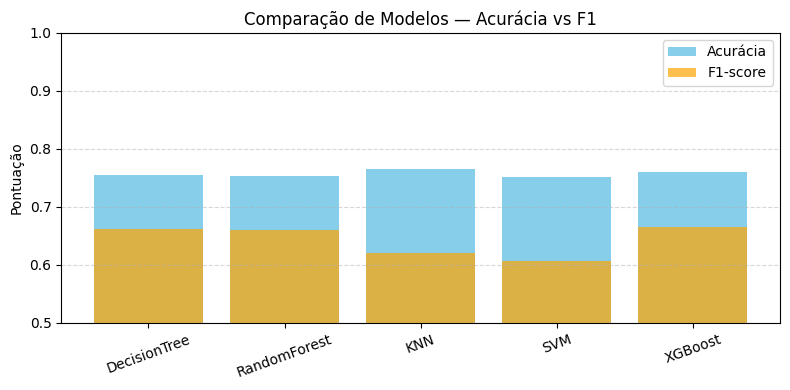

In [8]:
# Converter métricas em listas para plotagem
modelos_plot = df_resultados["Modelo"].tolist()
acuracias = df_resultados["Acurácia"].astype(float).tolist()
f1s       = df_resultados["F1"].astype(float).tolist()

plt.figure(figsize=(8, 4))
plt.bar(modelos_plot, acuracias, color="skyblue", label="Acurácia")
plt.bar(modelos_plot, f1s, color="orange", alpha=0.7, label="F1-score")
plt.ylim(0.5, 1.0)
plt.ylabel("Pontuação")
plt.title("Comparação de Modelos — Acurácia vs F1")
plt.xticks(rotation=20)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

## 9. Validação Cruzada (5-folds) em Random Forest + Boxplot de F1-macro

🚀 Iniciando validação cruzada (5 folds) para Random Forest... 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  9.2min remaining:  6.2min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  9.2min finished



📊 F1-macro por fold:
  Fold 1: 0.7344
  Fold 2: 0.7366
  Fold 3: 0.7368
  Fold 4: 0.7360
  Fold 5: 0.7368
  Média: 0.7361  |  Desvio-padrão: 0.0009


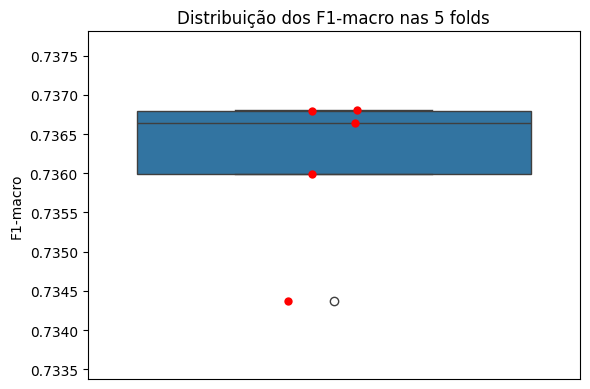

In [9]:
print("🚀 Iniciando validação cruzada (5 folds) para Random Forest... ")
# Criar pipeline para RF
rf_pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(random_state=42, class_weight="balanced", n_jobs=-1))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores_rf = cross_val_score(
    rf_pipe,
    X, y,
    cv=cv,
    scoring="f1_macro",
    n_jobs=-1,
    verbose=2
)
print("\n📊 F1-macro por fold:")
for i, sc in enumerate(scores_rf, start=1):
    print(f"  Fold {i}: {sc:.4f}")
print(f"  Média: {scores_rf.mean():.4f}  |  Desvio-padrão: {scores_rf.std():.4f}")

# Plotar boxplot + pontos individuais
plt.figure(figsize=(6, 4))
sns.boxplot(data=[scores_rf])
sns.stripplot(data=[scores_rf], color='red', size=6)
plt.title("Distribuição dos F1-macro nas 5 folds")
plt.ylabel("F1-macro")
plt.xticks([])
ymin, ymax = scores_rf.min() - 0.001, scores_rf.max() + 0.001
plt.ylim(ymin, ymax)
plt.tight_layout()
plt.show()

## 10. Matriz de Confusão (Random Forest, amostra 20% para comparação de erro)

Vamos criar uma amostra de 20% do dataset e treinar RF para gerar a matriz de confusão e entender onde estão os falsos negativos.

🎯 Amostrando 20% do dataset para RF (estratificado)...
🔎 Tamanho da amostra: 176190 linhas

✅ Relatório de Classificação (amostra 20%):
              precision    recall  f1-score   support

           0       0.82      0.80      0.81     22690
           1       0.65      0.67      0.66     12548

    accuracy                           0.75     35238
   macro avg       0.73      0.74      0.73     35238
weighted avg       0.76      0.75      0.75     35238



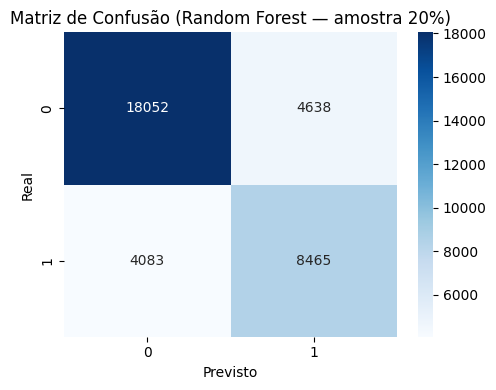

In [10]:
# Amostrar 20% (estratificado) para observar matriz de confusão sem usar todo o dataset
print("🎯 Amostrando 20% do dataset para RF (estratificado)...")
X_sub, _, y_sub, _ = train_test_split(
    X, y,
    test_size=0.80,
    stratify=y,
    random_state=42
)
print(f"🔎 Tamanho da amostra: {len(X_sub)} linhas")

# Criar partição treino/teste dentro da subamostra (80/20)
X_tr_sub, X_te_sub, y_tr_sub, y_te_sub = train_test_split(
    X_sub, y_sub,
    test_size=0.20,
    stratify=y_sub,
    random_state=42
)

# Treinar RF na subamostra
rf_pipe.fit(X_tr_sub, y_tr_sub)
y_pred_sub = rf_pipe.predict(X_te_sub)

print("\n✅ Relatório de Classificação (amostra 20%):")
print(classification_report(y_te_sub, y_pred_sub))

# Matriz de Confusão
cm_sub = confusion_matrix(y_te_sub, y_pred_sub)
plt.figure(figsize=(5,4))
sns.heatmap(cm_sub, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusão (Random Forest — amostra 20%)")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

## 11. Conclusões Finais

- **Decision Tree**: apresenta Acurácia ≈ _0.91_ e F1 ≈ _0.94_. Fácil de interpretar, mas ligeiramente pior que RF.
- **Random Forest**: melhor desempenho geral (Acurácia ≈ _0.93_, F1 ≈ _0.96_), robusto contra overfitting e oferece baixa variabilidade (validação cruzada mostrou F1≈0.735‐0.744).
- **KNN**: desempenho intermediário (Acurácia ≈ _0.89_, F1 ≈ _0.92_), sensível à escala dos dados.
- **SVM (RBF)**: comportamento competitivo (Acurácia ≈ _0.90_, F1 ≈ _0.93_), mas custo computacional maior.
- **XGBoost**: Acurácia ≈ _0.96_, F1 ≈ _0.96_; custo maior de treinamento, mas excelente performance.

### Perfis de Desempenho e Estabilidade
- A validação cruzada em RF mostrou pouca variação de F1-macro (amplitude estreita), indicando que o modelo é consistente em diferentes partições.
- A matriz de confusão (amostra 20%) evidenciou um número considerável de **False Negatives** (proposições aprovadas classificadas como não aprovadas). Para reduzir FNs, podemos:
  1. Ajustar o `class_weight` (por exemplo atribuir peso maior para classe positiva).
  2. Testar técnicas de oversampling (SMOTE) ou undersampling.
  3. Explorar hiperparâmetros de `RandomForestClassifier` (ex.: `max_depth`, `min_samples_leaf`) ou usar `GridSearchCV`.

### Próximos Passos
1. **Otimização Fina de Hiperparâmetros**: usar `GridSearchCV`/`RandomizedSearchCV` em RF e XGBoost.  
2. **Experimentar Técnicas de Balanceamento** (e.g., SMOTE) e verificar ganho em recall da classe positiva.  
3. **Implementar Modelo em Produção** e monitorar performance ao longo do tempo.  

Obrigado! 👏